# Clean Wavelength Selection Validation Pipeline

This notebook provides a clean, step-by-step validation of the wavelength selection algorithm.

## Pipeline Overview:
1. **Load masked data** and ground truth
2. **Run baseline Concatenated KMeans** on full data
3. **Train autoencoder** and perform wavelength selection
4. **Extract selected wavelengths** from original data
5. **Run Concatenated KMeans** on selected subset
6. **Compare metrics** between full and selected data

Each step is tracked with clear metrics and explanations.

## Setup and Imports

In [45]:
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
import random
random.seed(42)
import torch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Add paths
base_dir = Path(r"C:\Users\meloy\PycharmProjects\Capstone")
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "wavelength_analysis"))

print("Environment setup completed!")
print(f"Working directory: {base_dir}")
print(f"Random seed: 42 (fixed for reproducibility)")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Environment setup completed!
Working directory: C:\Users\meloy\PycharmProjects\Capstone
Random seed: 42 (fixed for reproducibility)
Device: CUDA


In [46]:
# Import required modules
from wavelength_analysis.core.config import AnalysisConfig
from wavelength_analysis.core.analyzer import WavelengthAnalyzer
from concatenation_clustering import (
    load_masked_data,
    concatenate_hyperspectral_data,
    perform_clustering,
    reconstruct_cluster_map
)
from ground_truth_validation import (
    extract_ground_truth_from_png,
    calculate_clustering_accuracy
)

print("All modules imported successfully!")

All modules imported successfully!


## Step 1: Load Data and Ground Truth

Load the masked hyperspectral data and extract ground truth labels from PNG annotation.

In [47]:
# Define paths
sample_name = "Lichens"
data_path = base_dir / "data" / "processed" / sample_name / "lichens_data_masked.pkl"
mask_path = base_dir / "data" / "processed" / sample_name / "lichens_mask.npy"
png_path = Path(r"C:\Users\meloy\Downloads\Mask_Manual.png")

print(f"Sample: {sample_name}")
print(f"Data path: {data_path}")
print(f"Mask path: {mask_path}")
print(f"Ground truth PNG: {png_path}")

Sample: Lichens
Data path: C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl
Mask path: C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy
Ground truth PNG: C:\Users\meloy\Downloads\Mask_Manual.png


In [48]:
# Load hyperspectral data
print("Loading masked hyperspectral data...")
full_data = load_masked_data(data_path)

print(f"\n✓ Data loaded successfully")
print(f"  - Excitation wavelengths: {full_data['excitation_wavelengths']}")
print(f"  - Number of excitations: {len(full_data['excitation_wavelengths'])}")

# Check data shape for each excitation
print("\n📊 Data dimensions per excitation:")
for ex in full_data['excitation_wavelengths']:
    ex_str = str(ex)
    cube_shape = full_data['data'][ex_str]['cube'].shape
    wavelengths = full_data['data'][ex_str]['wavelengths']
    print(f"  - {ex} nm: {cube_shape} (H×W×Bands), wavelengths: {len(wavelengths)} bands")

Loading masked hyperspectral data...

✓ Data loaded successfully
  - Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
  - Number of excitations: 8

📊 Data dimensions per excitation:
  - 310.0 nm: (1040, 1392, 22) (H×W×Bands), wavelengths: 22 bands
  - 325.0 nm: (1040, 1392, 22) (H×W×Bands), wavelengths: 22 bands
  - 340.0 nm: (1040, 1392, 22) (H×W×Bands), wavelengths: 22 bands
  - 365.0 nm: (1040, 1392, 27) (H×W×Bands), wavelengths: 27 bands
  - 385.0 nm: (1040, 1392, 28) (H×W×Bands), wavelengths: 28 bands
  - 400.0 nm: (1040, 1392, 25) (H×W×Bands), wavelengths: 25 bands
  - 415.0 nm: (1040, 1392, 24) (H×W×Bands), wavelengths: 24 bands
  - 430.0 nm: (1040, 1392, 22) (H×W×Bands), wavelengths: 22 bands


Extracting ground truth from PNG annotation...

Original PNG shape: (1024, 1392)
Resized to: (1040, 1392)
Found 8 unique colors in the PNG
Found 6 lichen type colors (excluding background)

Ground Truth Statistics:
  Shape: (1040, 1392)
  Number of lichen types: 6
  Type 0 (color (np.uint8(48), np.uint8(48), np.uint8(48), np.uint8(255))): 104162 pixels (7.20%)
  Type 1 (color (np.uint8(72), np.uint8(72), np.uint8(72), np.uint8(255))): 69258 pixels (4.78%)
  Type 2 (color (np.uint8(96), np.uint8(96), np.uint8(96), np.uint8(255))): 123960 pixels (8.56%)
  Type 3 (color (np.uint8(120), np.uint8(120), np.uint8(120), np.uint8(255))): 95261 pixels (6.58%)
  Type 4 (color (np.uint8(144), np.uint8(144), np.uint8(144), np.uint8(255))): 101597 pixels (7.02%)
  Type 5 (color (np.uint8(217), np.uint8(217), np.uint8(217), np.uint8(255))): 79449 pixels (5.49%)
  Background: 873993 pixels (60.37%)

✓ Ground truth extracted
  - Number of lichen types: 6
  - Ground truth shape: (1040, 1392)
  - Unique 

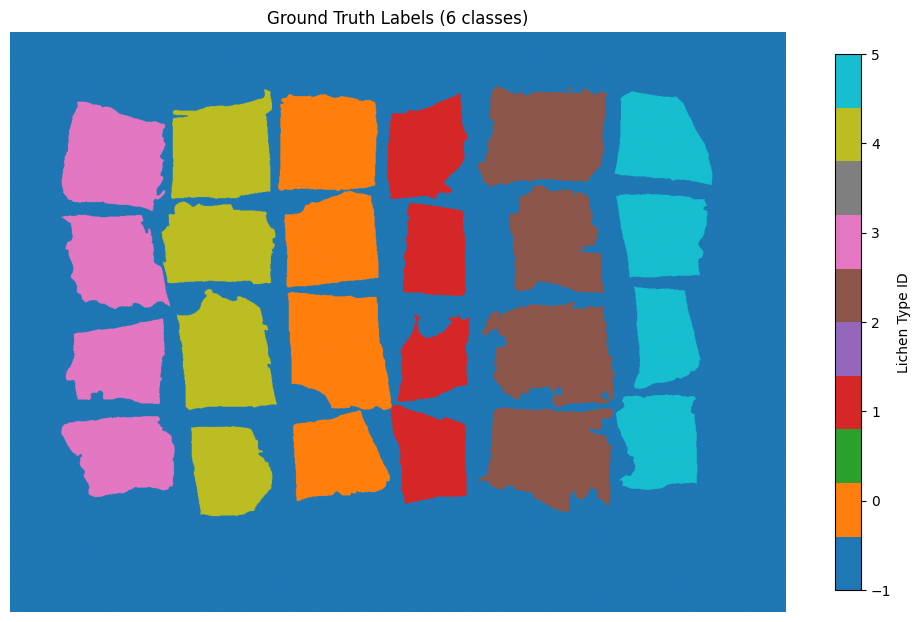

In [49]:
# Extract ground truth from PNG
print("Extracting ground truth from PNG annotation...\n")

background_colors = [
    (24, 24, 24, 255),      # Dark gray background
    (168, 168, 168, 255)    # Light gray background
]

ground_truth, color_mapping, lichen_colors = extract_ground_truth_from_png(
    png_path,
    background_colors=background_colors,
    target_shape=(1040, 1392)
)

n_true_classes = len(lichen_colors)
print(f"\n✓ Ground truth extracted")
print(f"  - Number of lichen types: {n_true_classes}")
print(f"  - Ground truth shape: {ground_truth.shape}")
print(f"  - Unique labels: {np.unique(ground_truth)}")

# Visualize ground truth
plt.figure(figsize=(10, 7))
plt.imshow(ground_truth, cmap='tab10')
plt.colorbar(label='Lichen Type ID', shrink=0.8)
plt.title(f'Ground Truth Labels ({n_true_classes} classes)')
plt.axis('off')
plt.tight_layout()
plt.show()

## Step 2: Baseline - Concatenated KMeans on Full Data

Run KMeans clustering on the full concatenated hyperspectral data as our baseline.

In [50]:
print("="*80)
print("BASELINE: Concatenated KMeans on Full Data")
print("="*80)

# Concatenate all wavelength data
print("\nConcatenating full hyperspectral data...")
df_full, valid_mask_full, metadata_full = concatenate_hyperspectral_data(
    full_data,
    normalize=True,
    scale=True
)

print(f"\n✓ Data concatenated")
print(f"  - DataFrame shape: {df_full.shape}")
print(f"  - Number of pixels: {df_full.shape[0]:,}")
print(f"  - Number of features: {df_full.shape[1] - 2:,} (excluding x, y coordinates)")
print(f"  - Valid mask pixels: {np.sum(valid_mask_full):,}")

BASELINE: Concatenated KMeans on Full Data

Concatenating full hyperspectral data...
Starting data concatenation...
Found 8 excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Spatial dimensions: 1040 x 1392
Finding valid pixels...
Found 573687 valid pixels out of 1447680 total (39.6%)
Concatenating spectral data...
Created DataFrame with shape: (573687, 194)
  - 573687 pixels (rows)
  - 194 features (columns): 2 coordinates + 192 spectral features
Applying standard scaling to spectral features...

✓ Data concatenated
  - DataFrame shape: (573687, 194)
  - Number of pixels: 573,687
  - Number of features: 192 (excluding x, y coordinates)
  - Valid mask pixels: 573,687


In [51]:
# Perform KMeans clustering on full data
print(f"\nPerforming KMeans clustering with k={n_true_classes}...")

labels_full, metrics_full = perform_clustering(
    df_full,
    n_clusters=n_true_classes,
    method='kmeans',
    use_pca=False,
    random_state=42
)

# Reconstruct cluster map
cluster_map_full = reconstruct_cluster_map(
    labels_full, 
    df_full, 
    valid_mask_full, 
    metadata_full
)

print("\n✓ Clustering completed")
print(f"  - Unique clusters: {np.unique(labels_full[labels_full >= 0])}")
print(f"  - Silhouette score: {metrics_full['silhouette_score']:.4f}")
print(f"  - Davies-Bouldin score: {metrics_full['davies_bouldin_score']:.4f}")
print(f"  - Calinski-Harabasz score: {metrics_full['calinski_harabasz_score']:.2f}")


Performing KMeans clustering with k=6...

Performing kmeans clustering with 6 clusters...
Clustering on 573687 samples with 192 features
Running KMeans...
KMeans inertia: 26709055.72
Calculating clustering metrics...
Silhouette Score: 0.2614
Davies-Bouldin Score: 1.1310
Calinski-Harabasz Score: 358434.97

Cluster distribution:
  Cluster 0: 90076 pixels (15.7%)
  Cluster 1: 96196 pixels (16.8%)
  Cluster 2: 211040 pixels (36.8%)
  Cluster 3: 127181 pixels (22.2%)
  Cluster 4: 35069 pixels (6.1%)
  Cluster 5: 14125 pixels (2.5%)

✓ Clustering completed
  - Unique clusters: [0 1 2 3 4 5]
  - Silhouette score: 0.2614
  - Davies-Bouldin score: 1.1310
  - Calinski-Harabasz score: 358434.97



Validating baseline against ground truth...

BASELINE METRICS (Full Data)

📊 Clustering Quality Metrics:
  • Purity: 0.4654
    - Measures the extent to which clusters contain a single class
    - Range: [0, 1], higher is better
    - Formula: (1/N) * Σ max(|cluster_k ∩ class_j|)

  • Adjusted Rand Index (ARI): 0.2185
    - Measures similarity between clustering and ground truth
    - Range: [-1, 1], 1 = perfect match, 0 = random clustering

  • Normalized Mutual Information (NMI): 0.3087
    - Measures mutual dependence between clustering and ground truth
    - Range: [0, 1], higher is better

  • V-measure: 0.3087
    - Harmonic mean of homogeneity and completeness
    - Range: [0, 1], higher is better

  • Homogeneity: 0.2895
    - All clusters contain only members of a single class

  • Completeness: 0.3306
    - All members of a class are assigned to the same cluster


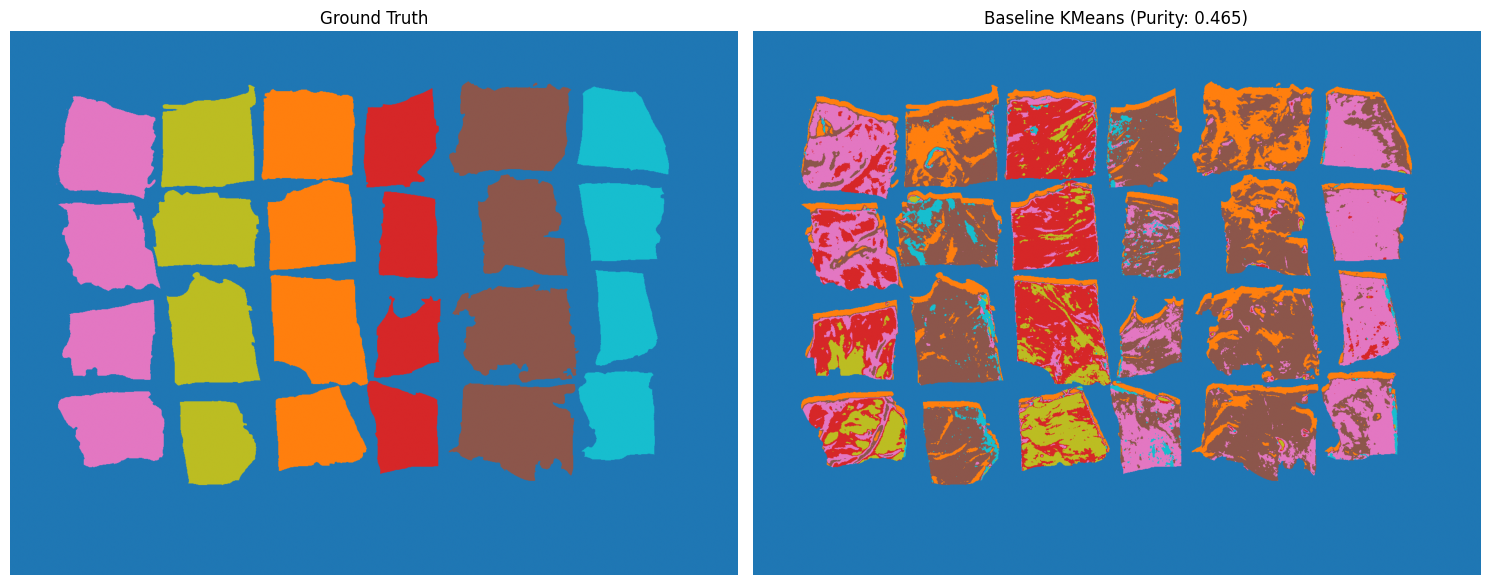

In [52]:
# Calculate ground truth metrics for baseline
print("\nValidating baseline against ground truth...")

baseline_metrics = calculate_clustering_accuracy(
    cluster_map_full, 
    ground_truth, 
    valid_mask_full
)

print("\n" + "="*50)
print("BASELINE METRICS (Full Data)")
print("="*50)
print("\n📊 Clustering Quality Metrics:")
print(f"  • Purity: {baseline_metrics['purity']:.4f}")
print(f"    - Measures the extent to which clusters contain a single class")
print(f"    - Range: [0, 1], higher is better")
print(f"    - Formula: (1/N) * Σ max(|cluster_k ∩ class_j|)")

print(f"\n  • Adjusted Rand Index (ARI): {baseline_metrics['adjusted_rand_score']:.4f}")
print(f"    - Measures similarity between clustering and ground truth")
print(f"    - Range: [-1, 1], 1 = perfect match, 0 = random clustering")

print(f"\n  • Normalized Mutual Information (NMI): {baseline_metrics['normalized_mutual_info']:.4f}")
print(f"    - Measures mutual dependence between clustering and ground truth")
print(f"    - Range: [0, 1], higher is better")

print(f"\n  • V-measure: {baseline_metrics['v_measure']:.4f}")
print(f"    - Harmonic mean of homogeneity and completeness")
print(f"    - Range: [0, 1], higher is better")

print(f"\n  • Homogeneity: {baseline_metrics['homogeneity']:.4f}")
print(f"    - All clusters contain only members of a single class")

print(f"\n  • Completeness: {baseline_metrics['completeness']:.4f}")
print(f"    - All members of a class are assigned to the same cluster")

# Visualize baseline clustering
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Ground truth
axes[0].imshow(ground_truth, cmap='tab10')
axes[0].set_title('Ground Truth')
axes[0].axis('off')

# Baseline clustering
axes[1].imshow(cluster_map_full, cmap='tab10')
axes[1].set_title(f'Baseline KMeans (Purity: {baseline_metrics["purity"]:.3f})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 3: Wavelength Selection Function

Create a modular function that performs wavelength selection and returns the selected wavelength indices.

In [53]:
def select_informative_wavelengths(data_path, mask_path, config_params, verbose=True):
    """
    Perform wavelength selection using autoencoder-based analysis.
    
    Parameters:
    -----------
    data_path : Path
        Path to masked hyperspectral data
    mask_path : Path
        Path to mask file
    config_params : dict
        Configuration parameters for wavelength selection:
        - dimension_selection_method: 'activation', 'variance', or 'pca'
        - perturbation_method: 'percentile', 'standard_deviation', or 'absolute_range'
        - perturbation_magnitudes: list of magnitudes [low, medium, high]
        - n_important_dimensions: number of important latent dimensions
        - n_bands_to_select: number of wavelength bands to select
        - normalization_method: 'variance', 'max_per_excitation', or 'none'
    verbose : bool
        Print progress messages
    
    Returns:
    --------
    selected_wavelengths : list
        List of selected wavelength values
    importance_scores : dict
        Dictionary with wavelength importance scores and metadata
    """
    
    # Create model directory
    model_dir = base_dir / "results" / f"{sample_name}_wavelength_selection" / "model"
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / "autoencoder_model.pth"
    
    # Create configuration
    config = AnalysisConfig(
        sample_name=sample_name,
        data_path=str(data_path),
        mask_path=str(mask_path),
        model_path=str(model_path),
        dimension_selection_method=config_params.get('dimension_selection_method', 'activation'),
        perturbation_method=config_params.get('perturbation_method', 'percentile'),
        perturbation_magnitudes=config_params.get('perturbation_magnitudes', [10, 20, 30]),
        n_important_dimensions=config_params.get('n_important_dimensions', 15),
        n_bands_to_select=config_params.get('n_bands_to_select', 30),
        normalization_method=config_params.get('normalization_method', 'variance'),
        output_dir=str(model_dir.parent / "output"),
        save_tiff_layers=False,
        save_visualizations=True,
        n_baseline_patches=20
    )
    
    if verbose:
        print("\n" + "="*60)
        print("WAVELENGTH SELECTION")
        print("="*60)
        print(f"\nConfiguration:")
        print(f"  - Method: {config.dimension_selection_method}")
        print(f"  - Perturbation: {config.perturbation_method}")
        print(f"  - Important dimensions: {config.n_important_dimensions}")
        print(f"  - Bands to select: {config.n_bands_to_select}")
    
    # Initialize analyzer
    analyzer = WavelengthAnalyzer(config)
    
    # Load data and train/load model
    if verbose:
        print("\nLoading data and model...")
    analyzer.load_data_and_model()
    
    # Run wavelength selection analysis
    if verbose:
        print("\nPerforming wavelength selection analysis...")
    results = analyzer.run_complete_analysis()
    
    if results is None or 'selected_bands' not in results:
        raise ValueError("Wavelength selection failed to return results")
    
    selected_wavelengths = results['selected_bands']
    
    if verbose:
        print(f"\n✓ Selected {len(selected_wavelengths)} wavelengths:")
        print(f"  {selected_wavelengths[:10]}..." if len(selected_wavelengths) > 10 else f"  {selected_wavelengths}")
    
    # Return selected wavelengths and full results
    return selected_wavelengths, results

print("Wavelength selection function defined.")

Wavelength selection function defined.


## Step 4: Train Autoencoder and Select Wavelengths

Train the autoencoder model and use it to identify the most informative wavelengths.

In [54]:
# Define wavelength selection configuration
selection_config = {
    'dimension_selection_method': 'activation',  # How to select important latent dimensions
    'perturbation_method': 'percentile',         # How to perturb for sensitivity analysis
    'perturbation_magnitudes': [30, 50, 80],     # Perturbation levels
    'n_important_dimensions': 5,                # Number of important latent dimensions
    'n_bands_to_select': 10,                     # Number of wavelengths to select
    'normalization_method': 'variance'           # Normalization for importance scores
}

print("Wavelength Selection Configuration:")
for key, value in selection_config.items():
    print(f"  • {key}: {value}")

Wavelength Selection Configuration:
  • dimension_selection_method: activation
  • perturbation_method: percentile
  • perturbation_magnitudes: [30, 50, 80]
  • n_important_dimensions: 5
  • n_bands_to_select: 10
  • normalization_method: variance


In [55]:
# Perform wavelength selection
selected_bands_info, selection_results = select_informative_wavelengths(
    data_path, 
    mask_path, 
    selection_config,
    verbose=True
)

# Debug: Check what we got
print(f"\n=== DEBUG INFO ===")
print(f"Type of selected_bands_info: {type(selected_bands_info)}")
if isinstance(selected_bands_info, list) and len(selected_bands_info) > 0:
    print(f"Number of bands: {len(selected_bands_info)}")
    print(f"First element type: {type(selected_bands_info[0])}")
    print(f"First element keys: {selected_bands_info[0].keys() if isinstance(selected_bands_info[0], dict) else 'Not a dict'}")
    print(f"First element: {selected_bands_info[0]}")
    
# Extract just the emission wavelength values from the selected bands
# Each band is a dictionary with 'emission_wavelength' key
selected_wavelengths_list = []
for band in selected_bands_info:
    if isinstance(band, dict) and 'emission_wavelength' in band:
        # Get the emission wavelength value
        wl = band['emission_wavelength']
        # Convert numpy types to Python float if needed
        if hasattr(wl, 'item'):  # numpy scalar
            wl = wl.item()
        selected_wavelengths_list.append(wl)
    
# Remove duplicates while preserving order
seen = set()
unique_wavelengths = []
for wl in selected_wavelengths_list:
    if wl not in seen:
        seen.add(wl)
        unique_wavelengths.append(wl)
selected_wavelengths_list = unique_wavelengths

print(f"\n✓ Extracted {len(selected_wavelengths_list)} unique wavelength values")
print(f"Wavelengths: {selected_wavelengths_list}")


WAVELENGTH SELECTION

Configuration:
  - Method: activation
  - Perturbation: percentile
  - Important dimensions: 5
  - Bands to select: 10
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.

## Step 5: Extract Selected Wavelength Subset from Original Data

Use the selected wavelengths to create a subset of the original hyperspectral data.

In [56]:
def extract_wavelength_subset(full_data, selected_wavelengths, verbose=True):
    """
    Extract a subset of the hyperspectral data using selected wavelengths.
    
    Parameters:
    -----------
    full_data : dict
        Full hyperspectral data dictionary
    selected_wavelengths : list
        List of wavelength values to select
    verbose : bool
        Print progress messages
    
    Returns:
    --------
    subset_data : dict
        Subset of hyperspectral data with only selected wavelengths
    """
    
    subset_data = {
        'data': {},
        'metadata': full_data.get('metadata', {}),
        'excitation_wavelengths': full_data['excitation_wavelengths'],
        'selected_wavelengths': selected_wavelengths
    }
    
    total_bands_original = 0
    total_bands_selected = 0
    
    # Process each excitation wavelength
    for ex in full_data['excitation_wavelengths']:
        ex_str = str(ex)
        ex_data = full_data['data'][ex_str]
        
        original_wavelengths = np.array(ex_data['wavelengths'])
        original_cube = ex_data['cube']
        
        total_bands_original += len(original_wavelengths)
        
        # Find indices of selected wavelengths for this excitation
        selected_indices = []
        selected_wl_values = []
        
        for target_wl in selected_wavelengths:
            # Find closest wavelength in this excitation's data
            distances = np.abs(original_wavelengths - target_wl)
            closest_idx = np.argmin(distances)
            
            # Only include if the match is reasonably close (within 10 nm)
            if distances[closest_idx] < 10 and closest_idx not in selected_indices:
                selected_indices.append(closest_idx)
                selected_wl_values.append(original_wavelengths[closest_idx])
        
        if selected_indices:
            # Extract selected bands
            subset_cube = original_cube[:, :, selected_indices]
            total_bands_selected += len(selected_indices)
            
            subset_data['data'][ex_str] = {
                'cube': subset_cube,
                'wavelengths': selected_wl_values,
                **{k: v for k, v in ex_data.items() if k not in ['cube', 'wavelengths']}
            }
            
            if verbose:
                print(f"  Excitation {ex} nm: {len(selected_indices)}/{len(original_wavelengths)} bands selected")
        else:
            # No bands selected for this excitation
            subset_data['data'][ex_str] = ex_data
            if verbose:
                print(f"  Excitation {ex} nm: No bands selected, keeping all")
    
    if verbose:
        reduction_pct = (1 - total_bands_selected/total_bands_original) * 100
        print(f"\n📊 Data reduction: {total_bands_original} → {total_bands_selected} bands ({reduction_pct:.1f}% reduction)")
    
    return subset_data

print("Wavelength subset extraction function defined.")

Wavelength subset extraction function defined.


In [57]:
# Fix: Extract wavelength values from the dictionary list
print("Fixing wavelength extraction...")

# If selected_wavelengths_list contains dictionaries, extract the wavelength values
if len(selected_wavelengths_list) > 0 and isinstance(selected_wavelengths_list[0], dict):
    print(f"Converting {len(selected_wavelengths_list)} band dictionaries to wavelength values...")
    
    # Extract emission wavelength values
    wavelength_values = []
    for band in selected_wavelengths_list:
        if 'emission_wavelength' in band:
            wl = band['emission_wavelength']
            # Convert numpy types to Python float if needed
            if hasattr(wl, 'item'):
                wl = wl.item()
            wavelength_values.append(wl)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_wavelengths = []
    for wl in wavelength_values:
        if wl not in seen:
            seen.add(wl)
            unique_wavelengths.append(wl)
    
    # Replace the list
    selected_wavelengths_list = unique_wavelengths
    
    print(f"✓ Extracted {len(selected_wavelengths_list)} unique wavelength values")
    print(f"Wavelengths: {selected_wavelengths_list}")
    print(f"First wavelength type: {type(selected_wavelengths_list[0])}")
else:
    print("Wavelengths already in correct format")

Fixing wavelength extraction...
Wavelengths already in correct format


In [58]:
# Extract subset of data with selected wavelengths
print("\n" + "="*60)
print("EXTRACTING WAVELENGTH SUBSET")
print("="*60)
print("\nExtracting selected wavelengths from original data...\n")

# Debug: Check what we're passing
print(f"DEBUG: Type of selected_wavelengths_list: {type(selected_wavelengths_list)}")
print(f"DEBUG: Length: {len(selected_wavelengths_list)}")
if len(selected_wavelengths_list) > 0:
    print(f"DEBUG: First element: {selected_wavelengths_list[0]} (type: {type(selected_wavelengths_list[0])})")

subset_data = extract_wavelength_subset(
    full_data, 
    selected_wavelengths_list,  # Use the list, not the full results
    verbose=True
)


EXTRACTING WAVELENGTH SUBSET

Extracting selected wavelengths from original data...

DEBUG: Type of selected_wavelengths_list: <class 'list'>
DEBUG: Length: 7
DEBUG: First element: 420.0 (type: <class 'float'>)
  Excitation 310.0 nm: 7/22 bands selected
  Excitation 325.0 nm: 5/22 bands selected
  Excitation 340.0 nm: 2/22 bands selected
  Excitation 365.0 nm: 3/27 bands selected
  Excitation 385.0 nm: 4/28 bands selected
  Excitation 400.0 nm: 1/25 bands selected
  Excitation 415.0 nm: 2/24 bands selected
  Excitation 430.0 nm: 1/22 bands selected

📊 Data reduction: 192 → 25 bands (87.0% reduction)


## Step 6: Run Concatenated KMeans on Selected Subset

Apply the same clustering pipeline to the wavelength-selected data.

In [59]:
print("\n" + "="*80)
print("WAVELENGTH-SELECTED: Concatenated KMeans on Selected Data")
print("="*80)

# Concatenate selected wavelength data
print("\nConcatenating selected wavelength data...")
df_subset, valid_mask_subset, metadata_subset = concatenate_hyperspectral_data(
    subset_data,
    normalize=True,
    scale=True
)

print(f"\n✓ Data concatenated")
print(f"  - DataFrame shape: {df_subset.shape}")
print(f"  - Number of pixels: {df_subset.shape[0]:,}")
print(f"  - Number of features: {df_subset.shape[1] - 2:,} (excluding x, y coordinates)")
print(f"  - Feature reduction: {(df_full.shape[1] - 2) - (df_subset.shape[1] - 2)} features removed")


WAVELENGTH-SELECTED: Concatenated KMeans on Selected Data

Concatenating selected wavelength data...
Starting data concatenation...
Found 8 excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Spatial dimensions: 1040 x 1392
Finding valid pixels...
Found 573687 valid pixels out of 1447680 total (39.6%)
Concatenating spectral data...
Created DataFrame with shape: (573687, 27)
  - 573687 pixels (rows)
  - 27 features (columns): 2 coordinates + 25 spectral features
Applying standard scaling to spectral features...

✓ Data concatenated
  - DataFrame shape: (573687, 27)
  - Number of pixels: 573,687
  - Number of features: 25 (excluding x, y coordinates)
  - Feature reduction: 167 features removed


In [60]:
# Perform KMeans clustering on subset data
print(f"\nPerforming KMeans clustering with k={n_true_classes}...")

labels_subset, metrics_subset = perform_clustering(
    df_subset,
    n_clusters=n_true_classes,
    method='kmeans',
    use_pca=False,
    random_state=42
)

# Reconstruct cluster map
cluster_map_subset = reconstruct_cluster_map(
    labels_subset, 
    df_subset, 
    valid_mask_subset, 
    metadata_subset
)

print("\n✓ Clustering completed")
print(f"  - Unique clusters: {np.unique(labels_subset[labels_subset >= 0])}")
print(f"  - Silhouette score: {metrics_subset['silhouette_score']:.4f}")
print(f"  - Davies-Bouldin score: {metrics_subset['davies_bouldin_score']:.4f}")
print(f"  - Calinski-Harabasz score: {metrics_subset['calinski_harabasz_score']:.2f}")


Performing KMeans clustering with k=6...

Performing kmeans clustering with 6 clusters...
Clustering on 573687 samples with 25 features
Running KMeans...
KMeans inertia: 6704387.08
Calculating clustering metrics...
Silhouette Score: 0.1669
Davies-Bouldin Score: 1.3682
Calinski-Harabasz Score: 130710.06

Cluster distribution:
  Cluster 0: 23668 pixels (4.1%)
  Cluster 1: 183147 pixels (31.9%)
  Cluster 2: 227880 pixels (39.7%)
  Cluster 3: 134989 pixels (23.5%)
  Cluster 4: 3 pixels (0.0%)
  Cluster 5: 4000 pixels (0.7%)

✓ Clustering completed
  - Unique clusters: [0 1 2 3 4 5]
  - Silhouette score: 0.1669
  - Davies-Bouldin score: 1.3682
  - Calinski-Harabasz score: 130710.06


In [61]:
# Calculate ground truth metrics for subset
print("\nValidating wavelength-selected clustering against ground truth...")

subset_metrics = calculate_clustering_accuracy(
    cluster_map_subset, 
    ground_truth, 
    valid_mask_subset
)

print("\n" + "="*50)
print("WAVELENGTH-SELECTED METRICS")
print("="*50)
print("\n📊 Clustering Quality Metrics:")
print(f"  • Purity: {subset_metrics['purity']:.4f}")
print(f"  • Adjusted Rand Index (ARI): {subset_metrics['adjusted_rand_score']:.4f}")
print(f"  • Normalized Mutual Information (NMI): {subset_metrics['normalized_mutual_info']:.4f}")
print(f"  • V-measure: {subset_metrics['v_measure']:.4f}")
print(f"  • Homogeneity: {subset_metrics['homogeneity']:.4f}")
print(f"  • Completeness: {subset_metrics['completeness']:.4f}")


Validating wavelength-selected clustering against ground truth...

WAVELENGTH-SELECTED METRICS

📊 Clustering Quality Metrics:
  • Purity: 0.4516
  • Adjusted Rand Index (ARI): 0.2314
  • Normalized Mutual Information (NMI): 0.2934
  • V-measure: 0.2934
  • Homogeneity: 0.2490
  • Completeness: 0.3570


## Step 7: Compare Results

Compare the performance between full data and wavelength-selected data.

In [62]:
# Create comparison table
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

comparison_data = {
    'Metric': [
        'Number of Features',
        'Data Reduction (%)',
        'Purity',
        'Adjusted Rand Index',
        'Normalized Mutual Info',
        'V-measure',
        'Homogeneity', 
        'Completeness',
        'Silhouette Score',
        'Davies-Bouldin Score',
        'Calinski-Harabasz Score'
    ],
    'Full Data': [
        df_full.shape[1] - 2,
        0.0,
        baseline_metrics['purity'],
        baseline_metrics['adjusted_rand_score'],
        baseline_metrics['normalized_mutual_info'],
        baseline_metrics['v_measure'],
        baseline_metrics['homogeneity'],
        baseline_metrics['completeness'],
        metrics_full['silhouette_score'],
        metrics_full['davies_bouldin_score'],
        metrics_full['calinski_harabasz_score']
    ],
    'Selected Wavelengths': [
        df_subset.shape[1] - 2,
        (1 - (df_subset.shape[1] - 2)/(df_full.shape[1] - 2)) * 100,
        subset_metrics['purity'],
        subset_metrics['adjusted_rand_score'],
        subset_metrics['normalized_mutual_info'],
        subset_metrics['v_measure'],
        subset_metrics['homogeneity'],
        subset_metrics['completeness'],
        metrics_subset['silhouette_score'],
        metrics_subset['davies_bouldin_score'],
        metrics_subset['calinski_harabasz_score']
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Calculate differences
df_comparison['Difference'] = df_comparison['Selected Wavelengths'] - df_comparison['Full Data']
df_comparison['% Change'] = ((df_comparison['Selected Wavelengths'] - df_comparison['Full Data']) / 
                             df_comparison['Full Data'].abs()) * 100

# Format for display
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if abs(x) < 100 else f'{x:.2f}')
print(df_comparison.to_string(index=False))

# Reset display option
pd.reset_option('display.float_format')


PERFORMANCE COMPARISON
                 Metric  Full Data  Selected Wavelengths  Difference  % Change
     Number of Features     192.00               25.0000     -167.00  -86.9792
     Data Reduction (%)     0.0000               86.9792     86.9792       inf
                 Purity     0.4654                0.4516     -0.0138   -2.9623
    Adjusted Rand Index     0.2185                0.2314      0.0129    5.9038
 Normalized Mutual Info     0.3087                0.2934     -0.0152   -4.9397
              V-measure     0.3087                0.2934     -0.0152   -4.9397
            Homogeneity     0.2895                0.2490     -0.0404  -13.9671
           Completeness     0.3306                0.3570      0.0264    8.0013
       Silhouette Score     0.2614                0.1669     -0.0946  -36.1698
   Davies-Bouldin Score     1.1310                1.3682      0.2373   20.9821
Calinski-Harabasz Score  358434.97             130710.06  -227724.91  -63.5331


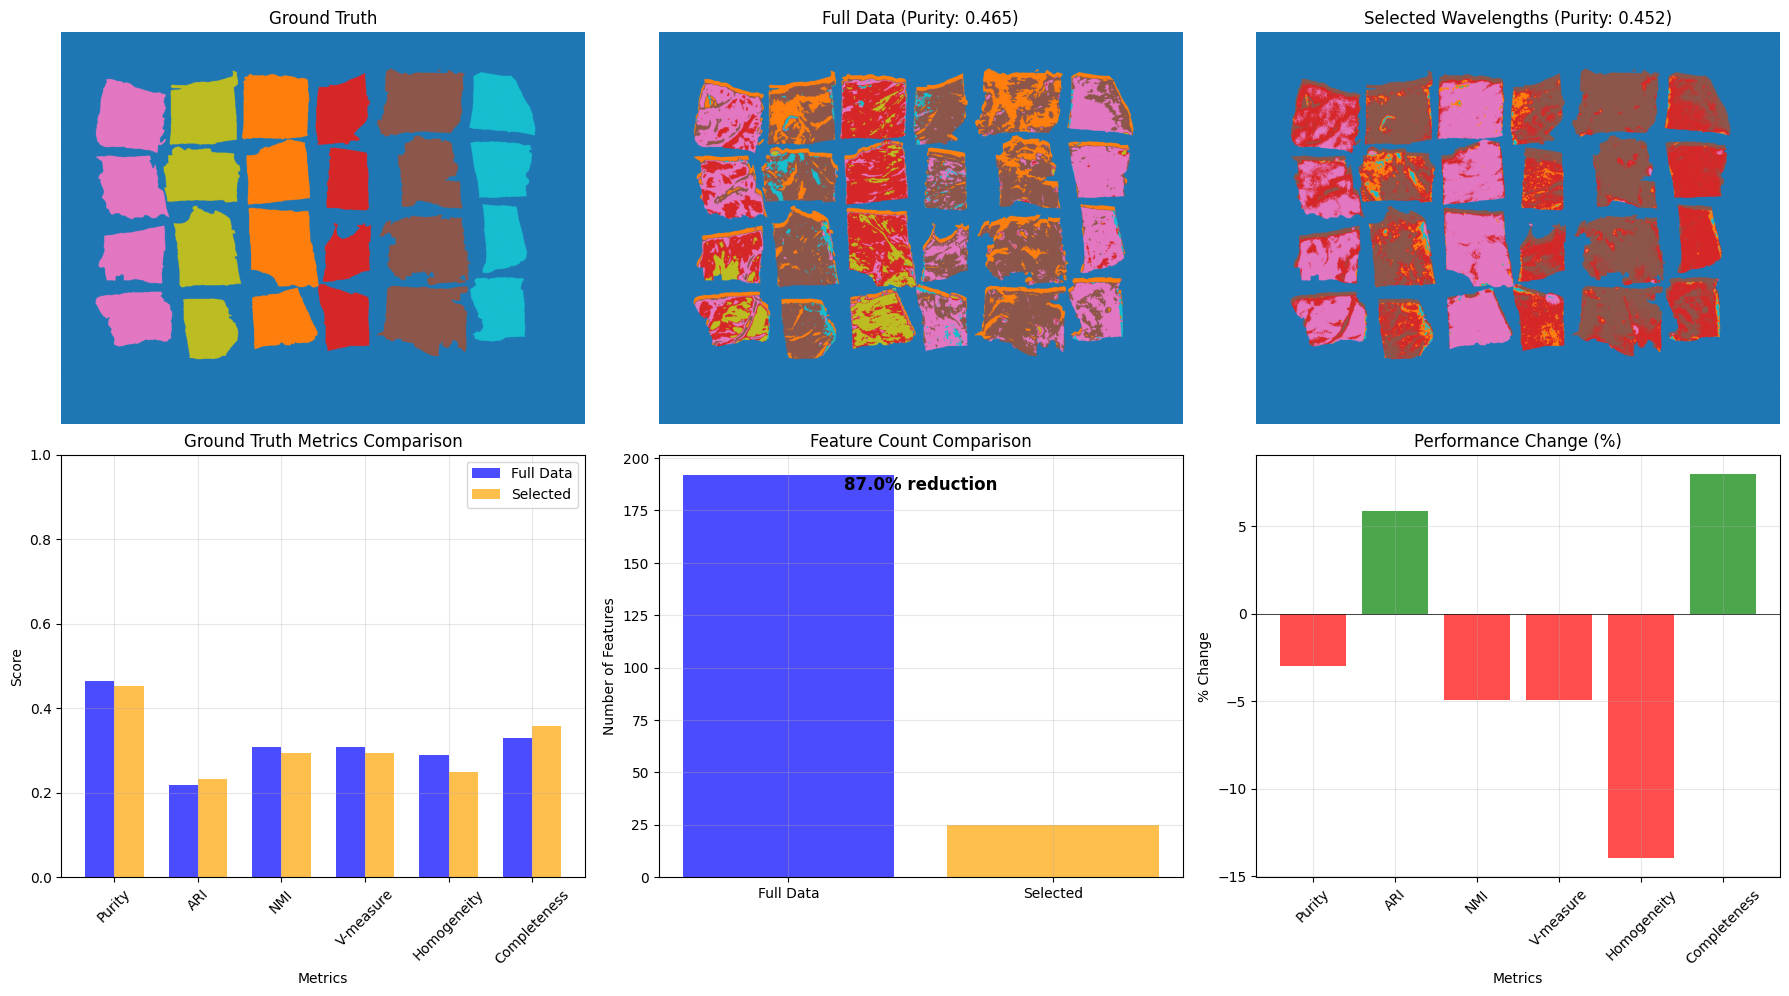

In [63]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Cluster maps
axes[0, 0].imshow(ground_truth, cmap='tab10')
axes[0, 0].set_title('Ground Truth')
axes[0, 0].axis('off')

axes[0, 1].imshow(cluster_map_full, cmap='tab10')
axes[0, 1].set_title(f'Full Data (Purity: {baseline_metrics["purity"]:.3f})')
axes[0, 1].axis('off')

axes[0, 2].imshow(cluster_map_subset, cmap='tab10')
axes[0, 2].set_title(f'Selected Wavelengths (Purity: {subset_metrics["purity"]:.3f})')
axes[0, 2].axis('off')

# Row 2: Metrics comparison
metrics_to_compare = ['purity', 'adjusted_rand_score', 'normalized_mutual_info', 
                      'v_measure', 'homogeneity', 'completeness']
metric_labels = ['Purity', 'ARI', 'NMI', 'V-measure', 'Homogeneity', 'Completeness']

x = np.arange(len(metric_labels))
width = 0.35

axes[1, 0].bar(x - width/2, [baseline_metrics[m] for m in metrics_to_compare], 
               width, label='Full Data', color='blue', alpha=0.7)
axes[1, 0].bar(x + width/2, [subset_metrics[m] for m in metrics_to_compare], 
               width, label='Selected', color='orange', alpha=0.7)
axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Ground Truth Metrics Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metric_labels, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Feature reduction visualization
axes[1, 1].bar(['Full Data', 'Selected'], 
               [df_full.shape[1] - 2, df_subset.shape[1] - 2],
               color=['blue', 'orange'], alpha=0.7)
axes[1, 1].set_ylabel('Number of Features')
axes[1, 1].set_title('Feature Count Comparison')
axes[1, 1].grid(True, alpha=0.3)

reduction_pct = (1 - (df_subset.shape[1] - 2)/(df_full.shape[1] - 2)) * 100
axes[1, 1].text(0.5, 0.95, f'{reduction_pct:.1f}% reduction', 
                transform=axes[1, 1].transAxes, ha='center', va='top',
                fontsize=12, fontweight='bold')

# Performance change
changes = [(subset_metrics[m] - baseline_metrics[m])/baseline_metrics[m] * 100 
           for m in metrics_to_compare]
colors = ['green' if c >= 0 else 'red' for c in changes]

axes[1, 2].bar(metric_labels, changes, color=colors, alpha=0.7)
axes[1, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 2].set_xlabel('Metrics')
axes[1, 2].set_ylabel('% Change')
axes[1, 2].set_title('Performance Change (%)')
axes[1, 2].set_xticklabels(metric_labels, rotation=45)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Insights

Summarize the key findings from the wavelength selection validation.

In [64]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

# Calculate key statistics
feature_reduction = (1 - (df_subset.shape[1] - 2)/(df_full.shape[1] - 2)) * 100
purity_change = (subset_metrics['purity'] - baseline_metrics['purity']) / baseline_metrics['purity'] * 100
ari_change = (subset_metrics['adjusted_rand_score'] - baseline_metrics['adjusted_rand_score']) / baseline_metrics['adjusted_rand_score'] * 100

print(f"\n📊 Data Reduction:")
print(f"  • Features: {df_full.shape[1] - 2} → {df_subset.shape[1] - 2} ({feature_reduction:.1f}% reduction)")
print(f"  • Selected wavelengths: {len(selected_wavelengths_list)} bands")

print(f"\n🎯 Performance Impact:")
print(f"  • Purity: {baseline_metrics['purity']:.4f} → {subset_metrics['purity']:.4f} ({purity_change:+.1f}%)")
print(f"  • ARI: {baseline_metrics['adjusted_rand_score']:.4f} → {subset_metrics['adjusted_rand_score']:.4f} ({ari_change:+.1f}%)")

print(f"\n💡 Key Insights:")
if purity_change > -5:
    print(f"  ✓ Wavelength selection successfully reduced data by {feature_reduction:.1f}%")
    print(f"    while maintaining comparable clustering performance.")
else:
    print(f"  ⚠ Wavelength selection reduced data by {feature_reduction:.1f}%")
    print(f"    but clustering performance decreased significantly.")

if subset_metrics['purity'] > 0.8:
    print(f"  ✓ Selected wavelengths achieve good clustering quality (Purity > 0.8)")
elif subset_metrics['purity'] > 0.6:
    print(f"  ⚠ Selected wavelengths achieve moderate clustering quality")
else:
    print(f"  ✗ Selected wavelengths result in poor clustering quality")

print(f"\n📝 Next Steps:")
print(f"  1. Test different wavelength selection configurations")
print(f"  2. Run bulk testing with various parameter combinations")
print(f"  3. Optimize for best trade-off between data reduction and performance")


SUMMARY

📊 Data Reduction:
  • Features: 192 → 25 (87.0% reduction)
  • Selected wavelengths: 7 bands

🎯 Performance Impact:
  • Purity: 0.4654 → 0.4516 (-3.0%)
  • ARI: 0.2185 → 0.2314 (+5.9%)

💡 Key Insights:
  ✓ Wavelength selection successfully reduced data by 87.0%
    while maintaining comparable clustering performance.
  ✗ Selected wavelengths result in poor clustering quality

📝 Next Steps:
  1. Test different wavelength selection configurations
  2. Run bulk testing with various parameter combinations
  3. Optimize for best trade-off between data reduction and performance


# Test alternative configuration
print("\n" + "="*80)
print("TESTING ALTERNATIVE CONFIGURATION")
print("="*80)

alternative_config = {
    'dimension_selection_method': 'variance',    # Different method
    'perturbation_method': 'standard_deviation', # Different perturbation
    'perturbation_magnitudes': [15, 30, 45],     # Different magnitudes
    'n_important_dimensions': 20,                # More dimensions
    'n_bands_to_select': 25,                     # Fewer bands (more aggressive)
    'normalization_method': 'max_per_excitation' # Different normalization
}

print("\nAlternative Configuration:")
for key, value in alternative_config.items():
    print(f"  • {key}: {value}")

In [65]:
# Run alternative configuration
selected_bands_alt_raw, selection_results_alt = select_informative_wavelengths(
    data_path, 
    mask_path, 
    alternative_config,
    verbose=True
)

# DEBUG AND FIX: The function returns dictionaries, not wavelength values!
print("\n=== DEBUGGING WAVELENGTH EXTRACTION ===")
print(f"Type returned: {type(selected_bands_alt_raw)}")
if isinstance(selected_bands_alt_raw, list) and len(selected_bands_alt_raw) > 0:
    print(f"First element: {selected_bands_alt_raw[0]}")
    print(f"Type of first element: {type(selected_bands_alt_raw[0])}")

# EXTRACT JUST THE WAVELENGTH VALUES FROM THE DICTIONARIES
selected_wavelengths_alt = []
for item in selected_bands_alt_raw:
    if isinstance(item, dict):
        if 'emission_wavelength' in item:
            wl_value = item['emission_wavelength']
            # Convert numpy to regular float if needed
            if hasattr(wl_value, 'item'):
                wl_value = float(wl_value.item())
            else:
                wl_value = float(wl_value)
            selected_wavelengths_alt.append(wl_value)
    elif isinstance(item, (int, float)):
        # If it's already a number, just use it
        selected_wavelengths_alt.append(float(item))

# Remove duplicates while preserving order
seen = set()
unique_wavelengths_alt = []
for wl in selected_wavelengths_alt:
    if wl not in seen:
        seen.add(wl)
        unique_wavelengths_alt.append(wl)

selected_wavelengths_alt = unique_wavelengths_alt

print(f"\n✓ Successfully extracted {len(selected_wavelengths_alt)} unique wavelength values")
print(f"Values are: {selected_wavelengths_alt}")
print(f"Type check - first value: {selected_wavelengths_alt[0]} (type: {type(selected_wavelengths_alt[0])})")

# NOW extract subset with the ACTUAL WAVELENGTH VALUES
print("\nExtracting alternative wavelength subset...\n")
subset_data_alt = extract_wavelength_subset(
    full_data, 
    selected_wavelengths_alt,  # This is now guaranteed to be a list of floats
    verbose=True
)

# Concatenate and cluster
print("\nConcatenating and clustering...")
df_subset_alt, valid_mask_alt, metadata_alt = concatenate_hyperspectral_data(
    subset_data_alt,
    normalize=True,
    scale=True
)

labels_alt, metrics_alt = perform_clustering(
    df_subset_alt,
    n_clusters=n_true_classes,
    method='kmeans',
    use_pca=False,
    random_state=42
)

cluster_map_alt = reconstruct_cluster_map(
    labels_alt, 
    df_subset_alt, 
    valid_mask_alt, 
    metadata_alt
)

# Validate
alt_metrics = calculate_clustering_accuracy(
    cluster_map_alt, 
    ground_truth, 
    valid_mask_alt
)

print("\n" + "="*50)
print("ALTERNATIVE CONFIGURATION RESULTS")
print("="*50)
print(f"\n📊 Performance:")
print(f"  • Features: {df_subset_alt.shape[1] - 2} (from {df_full.shape[1] - 2})")
print(f"  • Purity: {alt_metrics['purity']:.4f}")
print(f"  • ARI: {alt_metrics['adjusted_rand_score']:.4f}")
print(f"  • NMI: {alt_metrics['normalized_mutual_info']:.4f}")


WAVELENGTH SELECTION

Configuration:
  - Method: variance
  - Perturbation: standard_deviation
  - Important dimensions: 20
  - Bands to select: 25
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitati

In [66]:
# Run alternative configuration
selected_wavelengths_alt, selection_results_alt = select_informative_wavelengths(
    data_path, 
    mask_path, 
    alternative_config,
    verbose=True
)

# Extract subset
print("\nExtracting alternative wavelength subset...\n")
subset_data_alt = extract_wavelength_subset(
    full_data, 
    selected_wavelengths_alt, 
    verbose=True
)

# Concatenate and cluster
df_subset_alt, valid_mask_alt, metadata_alt = concatenate_hyperspectral_data(
    subset_data_alt,
    normalize=True,
    scale=True
)

labels_alt, metrics_alt = perform_clustering(
    df_subset_alt,
    n_clusters=n_true_classes,
    method='kmeans',
    use_pca=False,
    random_state=42
)

cluster_map_alt = reconstruct_cluster_map(
    labels_alt, 
    df_subset_alt, 
    valid_mask_alt, 
    metadata_alt
)

# Validate
alt_metrics = calculate_clustering_accuracy(
    cluster_map_alt, 
    ground_truth, 
    valid_mask_alt
)

print("\n" + "="*50)
print("ALTERNATIVE CONFIGURATION RESULTS")
print("="*50)
print(f"\n📊 Performance:")
print(f"  • Features: {df_subset_alt.shape[1] - 2} (from {df_full.shape[1] - 2})")
print(f"  • Purity: {alt_metrics['purity']:.4f}")
print(f"  • ARI: {alt_metrics['adjusted_rand_score']:.4f}")
print(f"  • NMI: {alt_metrics['normalized_mutual_info']:.4f}")


WAVELENGTH SELECTION

Configuration:
  - Method: variance
  - Perturbation: standard_deviation
  - Important dimensions: 20
  - Bands to select: 25
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitati

TypeError: unsupported operand type(s) for -: 'float' and 'dict'

In [ ]:
# Final comparison of all three approaches
print("\n" + "="*80)
print("FINAL COMPARISON: ALL APPROACHES")
print("="*80)

final_comparison = pd.DataFrame({
    'Approach': ['Baseline (Full)', 'Config 1', 'Config 2'],
    'Features': [
        df_full.shape[1] - 2,
        df_subset.shape[1] - 2,
        df_subset_alt.shape[1] - 2
    ],
    'Purity': [
        baseline_metrics['purity'],
        subset_metrics['purity'],
        alt_metrics['purity']
    ],
    'ARI': [
        baseline_metrics['adjusted_rand_score'],
        subset_metrics['adjusted_rand_score'],
        alt_metrics['adjusted_rand_score']
    ],
    'NMI': [
        baseline_metrics['normalized_mutual_info'],
        subset_metrics['normalized_mutual_info'],
        alt_metrics['normalized_mutual_info']
    ]
})

final_comparison['Reduction %'] = (1 - final_comparison['Features'] / final_comparison['Features'].iloc[0]) * 100

print(final_comparison.to_string(index=False))

print("\n✅ Pipeline validation complete!")
print("Ready for bulk configuration testing.")